![image-alt-text](Count_all_entries_in_the_dataset.png)


![Preview the first 10 rows](Preview_the_first_10_rows.png)

![Count distinct stations](Count_distinct_stations.png)

![Profile measurement types](Profile_measurement_types.png)

![Check date range in the dataset](Check_date_range_in_the_dataset.png)

![Average TMAX for one station](Average_TMAX_for_one_station.png)

![Monthly average TMAX for the station](Monthly_average_TMAX_for_the_statio.png)

![Monthly total precipitation for the station](Monthly_total_precipitation_for_the_station.png)

In [ ]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sa

server = "synapse-climatedatalake60301813-ondemand.sql.azuresynapse.net"
database = "ghcn_processed"
username = "student_user"
password = "StrongPassword!123"

engine = sa.create_engine(
    f"mssql+pyodbc://{username}:{password}@{server}:1433/{database}"
    "?driver=ODBC+Driver+17+for+SQL+Server"
)

query_prcp = """
SELECT date, precipitation_mm
FROM prcp_series
ORDER BY date;
"""

with engine.connect() as conn:
    # CORRECTED: Wrap the query in sa.text() for pandas read_sql
    df_prcp = pd.read_sql(sa.text(query_prcp), conn)

# Convert YYYYMMDD → datetime
df_prcp['date'] = pd.to_datetime(df_prcp['date'].astype(str), format='%Y%m%d')
print(df_prcp.head())

In [3]:
# Query the temperature data (tmax_series)
query_tmax = sa.text("""
SELECT date, max_temp_c
FROM tmax_series
ORDER BY date;
""")

with engine.connect() as conn:
    df_tmax = pd.read_sql(query_tmax, conn)

# Convert YYYYMMDD → datetime
df_tmax['date'] = pd.to_datetime(df_tmax['date'].astype(str), format='%Y%m%d')
print(df_tmax.head())


        date  max_temp_c
0 2023-01-01        12.8
1 2023-01-02        13.3
2 2023-01-03        14.4
3 2023-01-04        18.9
4 2023-01-05        10.0


In [5]:
# Merge temperature and precipitation by date
df_combined = pd.merge(df_prcp, df_tmax, on='date', how='inner')

# Extract year
df_combined['year'] = df_combined['date'].dt.year

print(df_combined.head())


        date  precipitation_mm  max_temp_c  year
0 2023-01-01               0.0        12.8  2023
1 2023-01-02               0.5        13.3  2023
2 2023-01-03              10.7        14.4  2023
3 2023-01-04               0.5        18.9  2023
4 2023-01-05               0.3        10.0  2023


   year  max_temp_c  precipitation_mm
0  2023   18.296986            1506.6
1  2024   18.317760            1178.0
2  2025   18.745489             751.4


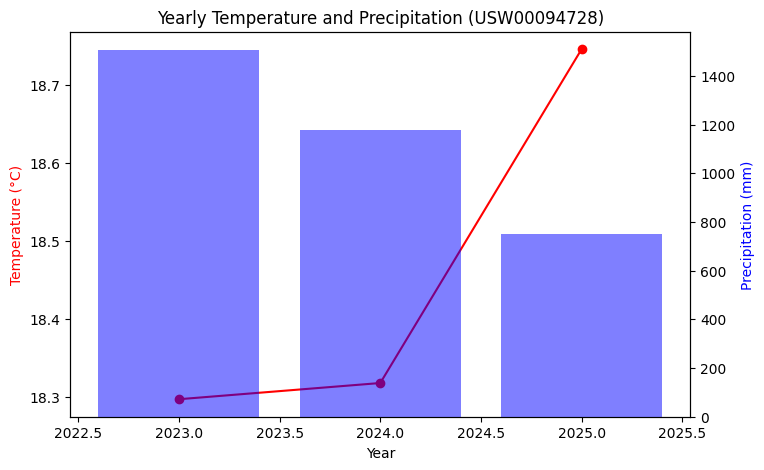

In [4]:
# Group by year
df_yearly = df_combined.groupby('year').agg({
    'max_temp_c': 'mean',
    'precipitation_mm': 'sum'
}).reset_index()

print(df_yearly)

# Plot
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(df_yearly['year'], df_yearly['max_temp_c'], 'r-o', label='Avg Max Temp (°C)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature (°C)', color='r')

ax2 = ax1.twinx()
ax2.bar(df_yearly['year'], df_yearly['precipitation_mm'], alpha=0.5, color='b', label='Total Precipitation (mm)')
ax2.set_ylabel('Precipitation (mm)', color='b')

plt.title('Yearly Temperature and Precipitation (USW00094728)')
plt.show()


In [5]:
# Calculate differences year-over-year
df_yearly['temp_diff'] = df_yearly['max_temp_c'].diff()
df_yearly['prcp_diff'] = df_yearly['precipitation_mm'].diff()

print(df_yearly[['year', 'temp_diff', 'prcp_diff']])


   year  temp_diff  prcp_diff
0  2023        NaN        NaN
1  2024   0.020773     -328.6
2  2025   0.427729     -426.6


In [6]:
query_prcp_la = sa.text("SELECT date, precipitation_mm FROM prcp_series_la ORDER BY date;")
query_tmax_la = sa.text("SELECT date, max_temp_c FROM tmax_series_la ORDER BY date;")

with engine.connect() as conn:
    df_prcp_la = pd.read_sql(query_prcp_la, conn)
    df_tmax_la = pd.read_sql(query_tmax_la, conn)

df_prcp_la['date'] = pd.to_datetime(df_prcp_la['date'].astype(str))
df_tmax_la['date'] = pd.to_datetime(df_tmax_la['date'].astype(str))

# Merge and analyze just like before
df_combined_la = pd.merge(df_prcp_la, df_tmax_la, on='date')
df_combined_la['year'] = df_combined_la['date'].dt.year
df_yearly_la = df_combined_la.groupby('year').agg({
    'max_temp_c': 'mean',
    'precipitation_mm': 'sum'
}).reset_index()

print(df_yearly_la)


   year  max_temp_c  precipitation_mm
0  2023   21.008493             367.1
1  2024   21.325137             283.6
2  2025   21.420225             125.4
